In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/')

In [ ]:
from InterpNN1D import *
import matplotlib.pyplot as plt ###Should print "cuda" otherwise something is wrong

Device: cuda
Final 1D Interp NN


In [ ]:
###Setup the parameter for our problem
n_controls = 2
N = 11
n_steps = 50
n_qubits=1

###PAULIS are written in the NN class, do not overwrite
H_drives = np.array([PAULIS["X"],PAULIS["Y"]],dtype='cfloat')
gpu_H_drives = torch.tensor(H_drives).to(device)  ###Always pass these to functions, these are stored on gpu


def excitation(theta):
    return torch.linalg.matrix_exp(-1j/2 * theta * torch.tensor(PAULIS["Z"]))

def gpu_excitation(theta):
    return torch.linalg.matrix_exp(-1j/2 * theta * torch.tensor(PAULIS["Z"]).to(device)) ###Always pass these to functions, these are stored on gpu

dt = 0.2 ###Timestep

theta_list = torch.tensor(np.linspace(0,2*pi,5000),dtype=float).to(device)

In [ ]:
T = torch.eye(2)+torch.randn(2,2)*0.1
T=T.to(device)

In [ ]:
model_path  = "/content/drive/MyDrive/XYControlRZ/Pretrained.pt"
###Create a model for transfer
transfer_model = FrozenNetwork1D(
    N = N,
    layers=1,
    width=50,
    initial_model = torch.load(model_path, map_location=device),
    dt=dt,
    n_steps =n_steps,
    operator=gpu_excitation,
    H_drives = gpu_H_drives,
    transfer_matrix = T
)

model = InterpolationNetwork1D(
    N = N, ###Number of theta values sampled by PICO
    layers=1, ###Number of hidden layers
    width = 50, ###Number of nodes in each hidden layer
    dt=dt, ###Timestep
    n_steps = n_steps, ###Number of timesteps
    operator = gpu_excitation, ###Operator to use
    H_drives=gpu_H_drives, ###Drive terms. For us, no drift
)
model.initialize_model(model_path)

Text(0.5, 1.0, 'Log Infidelity')

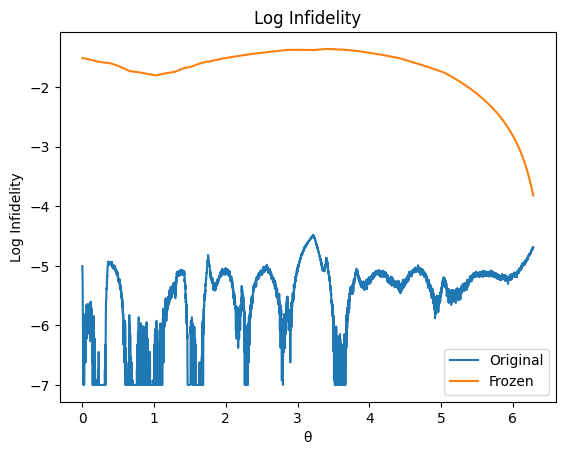

In [ ]:
log_infidelity_vals=model.infid_data(theta_list)
plt.plot(torch.Tensor.cpu(theta_list).detach().numpy(),torch.Tensor.cpu(log_infidelity_vals).detach().numpy(),label='Original')
log_infidelity_vals2=transfer_model.infid_data(theta_list)
plt.plot(torch.Tensor.cpu(theta_list).detach().numpy(),torch.Tensor.cpu(log_infidelity_vals2).detach().numpy(),label='Frozen')
plt.legend()
plt.xlabel('θ')
plt.ylabel('Log Infidelity')
plt.title("Log Infidelity")

In [ ]:
transfer_model.infid_loss(theta_list)

tensor(0.0257, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
losses = []
for i,v in enumerate(np.linspace(0,55,12)):
  print(f"Iteration {i}")
  l=[]
  for n in range(25):
    T = torch.eye(2)+torch.randn(2,2)*0.1
    T=T.to(device)
    batch_size = int(v)
    transfer_model = FrozenNetwork1D(
      N = N,
      layers=1,
      width=50,
      initial_model = torch.load(model_path, map_location=device),
      dt=dt,
      n_steps =n_steps,
      operator=gpu_excitation,
      H_drives = gpu_H_drives,
      transfer_matrix = T)

    callib = model.callibrated_pulses(transfer_matrix=T,theta_list=torch.linspace(0,2*pi,batch_size).to(device))
    if(batch_size > 0):
      transfer_model.frozen_train(callib, batch_size,lr = 1e-3,thresh=1e-4)
    l.append(torch.Tensor.cpu(transfer_model.infid_loss(theta_list)).detach().numpy())
  losses.append(l)

Iteration 0
Iteration 1
Iteration: 0 Loss: 0.001032155705615878
Iteration: 0 Loss: 0.0006217870395630598
Iteration: 100 Loss: 2.444303618176491e-06
Iteration: 0 Loss: 0.0001969383447431028
Iteration: 100 Loss: 8.147229095811781e-07
Iteration: 0 Loss: 0.0010829480597749352
Iteration: 100 Loss: 2.488831569280592e-06
Iteration: 0 Loss: 0.001044582575559616
Iteration: 100 Loss: 3.5038065107073635e-06
Iteration: 0 Loss: 0.001258231233805418
Iteration: 100 Loss: 2.7989226509816945e-06
Iteration: 0 Loss: 0.00042935259989462793
Iteration: 0 Loss: 0.0011514242505654693
Iteration: 100 Loss: 4.841067948291311e-06
Iteration: 0 Loss: 0.0010615544160827994
Iteration: 100 Loss: 5.283558948576683e-06
Iteration: 0 Loss: 0.00021474481036420912
Iteration: 100 Loss: 4.5784426561112923e-07
Iteration: 0 Loss: 0.0007847214001230896
Iteration: 100 Loss: 1.950738351297332e-06
Iteration: 0 Loss: 0.0007473589503206313
Iteration: 100 Loss: 2.2838205495645525e-06
Iteration: 0 Loss: 0.0009213072480633855
Iteration:

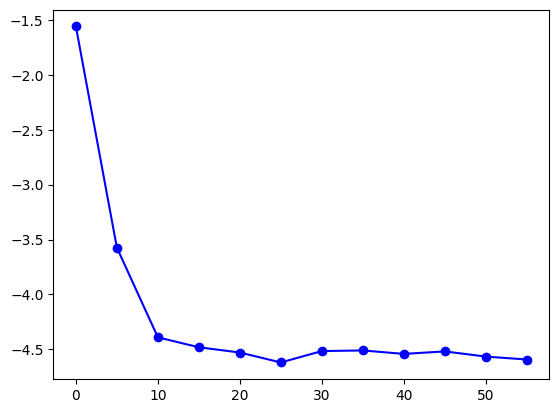

In [ ]:
plt.plot(np.linspace(0,55,12),np.mean(np.log10(np.array(losses)),axis=1),'-o',color='blue')

In [ ]:
pd.DataFrame(np.log10(np.array(losses))).to_csv("/content/drive/MyDrive/XYControlRZ/TransferRZ",index=False)